# Variational Bayes on Betabinomial mixture model for detecting mitochondria variants

In [ ]:
import bbmix
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt

In [2]:
AD = mmread("../../../Downloads/params_top500variants_frombb/top500ad.mtx").tocsc()
DP = mmread("../../../Downloads/params_top500variants_frombb/top500dp.mtx").tocsc()
AD.shape, DP.shape

((500, 81), (500, 81))

### Using binomial mixture for pre-filtering
Binomial mixture model has analytical solution, so it is much more statble. For variants without clear multiple components, Binomial mixture is sufficient to rule it out.

In [14]:
from bbmix.models import BinomialMixVB, BetaBinMixVB

ELBO_gain = np.zeros(AD.shape[0])
theta_all = np.zeros((AD.shape[0], 3))

for i in range(AD.shape[0]):
    _model1 = BinomialMixVB(n_obs=AD.shape[1], n_var=1, n_components=1)
    _model1.fit(AD[i, :], DP[i, :], min_iter=20)
    
    models_all = [] # multiple initials
    for it in range(15):
        _model2 = BinomialMixVB(n_obs=AD.shape[1], n_var=1, n_components=2)
        _model2.fit(AD[i, :], DP[i, :], min_iter=20)
        models_all.append(_model2)
    _model2 = models_all[np.argmax([x.ELBO_[-1] for x in models_all])]
    
    ELBO_gain[i] = _model2.ELBO_[-1] - _model1.ELBO_[-1]
    theta_all[i, :1] = _model1.theta_mu
    theta_all[i, 1:] = _model2.theta_mu

175 variants with >10 ELBO gain
11 variants with >100 ELBO gain


/Users/yuanhua/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/Users/yuanhua/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/yuanhua/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


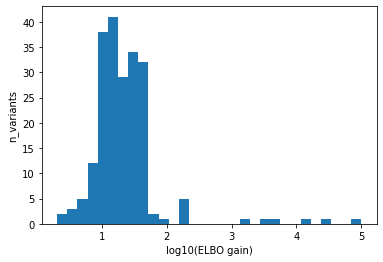

In [19]:
print("%d variants with >10 ELBO gain" %(np.sum(ELBO_gain > 10)))
print("%d variants with >100 ELBO gain" %(np.sum(ELBO_gain > 100)))

plt.hist(np.log10(ELBO_gain), bins=30)
plt.xlabel("log10(ELBO gain)")
plt.ylabel("n_variants")
plt.show()

### Further fitting with beta-binomial VB

In [ ]:
from bbmix.models import BinomialMixVB, BetaBinMixVB

ELBO_gain_BB = np.zeros(AD.shape[0])
theta_all_BB = np.zeros((AD.shape[0], 3))

eff_idx = np.where(ELBO_gain > 10)[0]
for i in eff_idx[:20]:
    _model_BB1 = BetaBinMixVB(n_obs=AD.shape[1], n_var=1, n_components=1)
    _model_BB1.fit(AD[i, :], DP[i, :], min_iter=20)
    
    _model_BB2 = BetaBinMixVB(n_obs=AD.shape[1], n_var=1, n_components=2)
    _model_BB2.fit(AD[i, :], DP[i, :], min_iter=20)
    
    ELBO_gain_BB[i] = _model_BB2.ELBO_[-1] - _model_BB1.ELBO_[-1]
    theta_all_BB[i, :1] = _model_BB1.theta_mu_hyper
    theta_all_BB[i, 1:] = _model_BB2.theta_mu_hyper

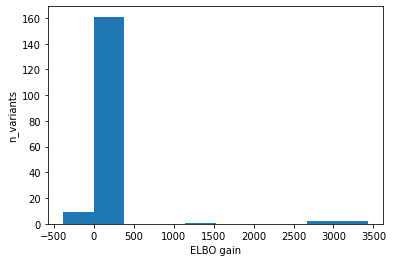

10 variants with >10 ELBO gain


In [46]:
plt.hist(ELBO_gain_BB[eff_idx])
plt.xlabel("ELBO gain")
plt.ylabel("n_variants")
plt.show()

print("%d variants with >10 ELBO gain" %(np.sum(ELBO_gain_BB > 10)))

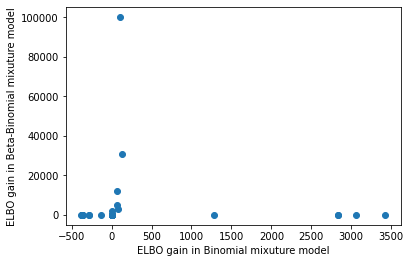

In [18]:
plt.plot(ELBO_gain_BB[eff_idx], ELBO_gain[eff_idx], 'o')
plt.xlabel("ELBO gain in Binomial mixuture model")
plt.ylabel("ELBO gain in Beta-Binomial mixuture model")
plt.show()

### Multivariant model

In [40]:
var_idx = np.where(ELBO_gain > 100)[0]
_model_BB = BetaBinMixVB(n_obs=AD.shape[1], n_var=len(var_idx), n_components=3)

_model_BB.fit(AD[var_idx, :], DP[var_idx, :], min_iter=20)
print(_model_BB.ELBO_[-1])

-6698.043808065797


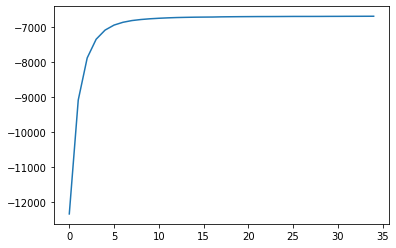

In [41]:
plt.plot(_model_BB.ELBO_)

In [42]:
_model_BB.theta_mu_hyper, _model_BB.theta_sum_hyper

(array([[9.67511571e-04, 4.22891078e-01, 9.87299681e-04],
        [1.44077399e-01, 2.63666754e-03, 2.47445938e-03],
        [3.42353818e-03, 4.97712842e-03, 1.86432524e-01],
        [1.82689627e-03, 2.03083418e-01, 4.95970103e-03],
        [6.39328754e-04, 4.11141070e-01, 2.07153610e-02],
        [2.42767547e-03, 2.80334758e-03, 1.95098313e-02],
        [1.21542160e-03, 4.58969709e-02, 1.02047944e-03],
        [7.84699925e-01, 7.53055960e-01, 7.79013084e-01],
        [2.34439354e-01, 2.32914629e-01, 2.25947208e-01],
        [2.35944719e-01, 2.34039688e-01, 2.26951126e-01],
        [2.69854405e-01, 2.69071353e-01, 2.61515830e-01]]),
 array([[1618.8108017 ,   65.63478082, 1681.61302093],
        [  89.28239092,  644.31419192,  899.92657953],
        [ 435.66968268,  482.04572707,    5.27412272],
        [1127.19113214,   46.53506009,  124.56749745],
        [1148.55767831,   52.5085963 ,    5.08112576],
        [ 457.7852326 ,  691.82072379,   12.26955902],
        [ 694.94962243,   41.7

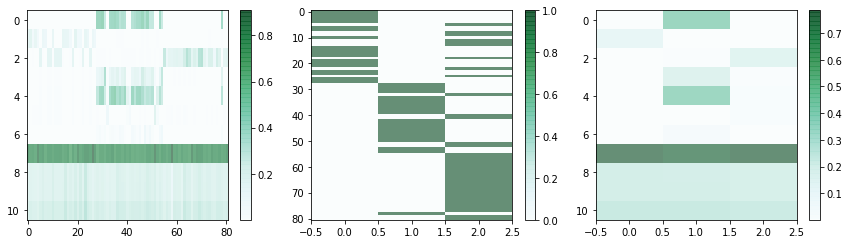

In [43]:
import vireoSNP

fig = plt.figure(figsize=(12, 3.5))
plt.subplot(1, 3, 1)
im = vireoSNP.plot.heat_matrix(_model_BB.theta_mu, display_value=False)
plt.colorbar(im)

plt.subplot(1, 3, 2)
im = vireoSNP.plot.heat_matrix(_model_BB.Z, display_value=False)
plt.colorbar(im)

plt.subplot(1, 3, 3)
im = vireoSNP.plot.heat_matrix(_model_BB.theta_mu_hyper, display_value=False)
plt.colorbar(im)

plt.tight_layout()
plt.show()